#PSF's on different coverslips

The purpose of this notebook is to show that for exactly the same collar correction setting each coverslip has a different PSF. I claim this is because each one is at a slightly different angle to the other.

In [1]:
%load_ext autoreload
%autoreload 1

#get our environment ready for data analysis times
%pylab inline

#import some os functionality so that we can be platform independent
import os

#import skimage components
from skimage.external import tifffile as tif #note that this can be achieved by using the
                                                #skimage.io with the tifffile plugin.
#better filtering than skimage
from scipy import ndimage

#import pandas
import pandas as pd

from scipy.ndimage import measurements
from scipy.ndimage.filters import median_filter

import matplotlib.gridspec as gridspec #fancy subplot layout

from matplotlib.path import Path #Needed to create shapes
import matplotlib.patches as patches #needed so show shapes on top of graphs

%aimport peaks.gauss2d
Gauss2D = peaks.gauss2d.Gauss2D

%aimport peaks.util
detrend = peaks.util.detrend

%aimport peaks.peakfinder
PeakFinder = peaks.peakfinder.PeakFinder

%aimport dphplotting.mip
mip = dphplotting.mip.mip

Populating the interactive namespace from numpy and matplotlib


In [2]:
PSF = tif.imread('testPSF.tif')

(<matplotlib.figure.Figure at 0x102c3de48>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x112e0ac50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x112dd1630>], dtype=object))

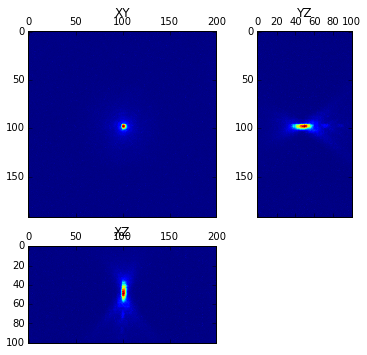

In [3]:
mip(PSF)

In [4]:
PSF.shape

(101, 192, 200)

In [5]:
def makeSlice(blob, width):
    y,x,w,m = blob
    return (slice(y-width//2,y+width//2), slice(x-width//2, x+width//2))

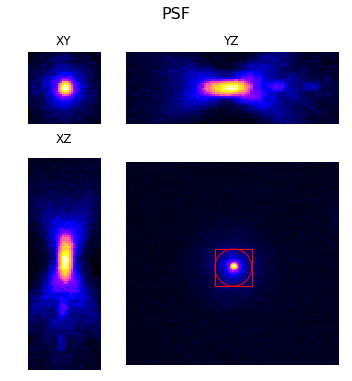

In [6]:
set_cmap('gnuplot2')
width = 35

datapeaks = PeakFinder(PSF.max(0),1.68,'norot')
datapeaks.find_blobs()
blob = datapeaks.remove_edge_blobs(width//2)[-1]
myslice = makeSlice(blob,width)
#print(myslice)
fig,axes = mip(log(PSF[:,myslice[0],myslice[1]]), allaxes = True)
axes[3].matshow(log(PSF.max(0)))

y,x,_,_ = blob
rect = plt.Rectangle((x-width/2,y-width/2),width,width, color='r', linewidth=1, fill=False)
circ = plt.Circle((x, y), radius=width/2, color='r', linewidth=1, fill=False)
axes[3].add_patch(circ)
axes[3].add_patch(rect)

for ax in axes:
    ax.axis('off')
fig.suptitle('PSF',y=1.05,fontsize=16)

#fig.savefig('mip_'+k.replace('.tif','.png'),dpi=300, transparent = True,bbox_inches='tight')

In [7]:
#find location of max intensity
my_max = unravel_index(PSF.argmax(),PSF.shape)
myslice = makeSlice([my_max[1],my_max[2],0,0],40)
myPSF = PSF[:,myslice[0],myslice[1]]
#set up dataframe for looking for stuff
peakfits = pd.DataFrame(columns=['amp', 'x0', 'y0', 'sigma_x', 'sigma_y', 'offset'])

#initial fit
max_z = Gauss2D(myPSF[my_max[0]])
max_z.optimize_params_ls()

peakfits.loc[my_max[0]] = max_z.opt_params_dict()
lastparams = max_z.opt_params
#forward fit
for f in range(my_max[0]+1, myPSF.shape[0]):
    fit = Gauss2D((myPSF[f]))
    fit.optimize_params_ls()
    peakfits.loc[f] = fit.opt_params_dict()
    #lastparams = fit.opt_params
    
#backward fit
lastparams = max_z.opt_params
for f in reversed(range(0, my_max[0])):
    fit = Gauss2D((myPSF[f]))
    fit.optimize_params_ls()
    peakfits.loc[f] = fit.opt_params_dict()
    #lastparams = fit.opt_params

Fitting error: Number of calls to function has reached maxfev = 1400.
Fitting error: Amplitude unphysical
Fitting error: Covariance of the parameters could not be estimated
Fitting error: Amplitude unphysical
Fitting error: Amplitude unphysical
Fitting error: Amplitude unphysical
Fitting error: Covariance of the parameters could not be estimated
Fitting error: Amplitude unphysical
Fitting error: Covariance of the parameters could not be estimated
Fitting error: Sigma larger than ROI
Fitting error: Amplitude unphysical
Fitting error: Amplitude unphysical
Fitting error: Covariance of the parameters could not be estimated
Fitting error: Amplitude unphysical
Fitting error: Amplitude unphysical
Fitting error: Covariance of the parameters could not be estimated
Fitting error: Amplitude unphysical
Fitting error: Amplitude unphysical
Fitting error: Number of calls to function has reached maxfev = 1400.
Fitting error: Amplitude unphysical
Fitting error: Amplitude unphysical
Fitting error: Ampli

In [8]:
peakfits = peakfits.abs()

In [9]:
peakfits.sort(inplace=True)

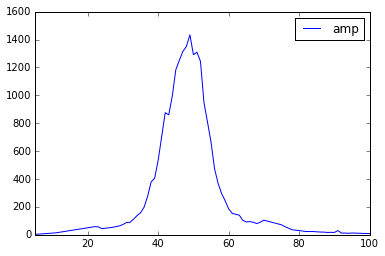

In [10]:
peakfits.plot(y='amp')

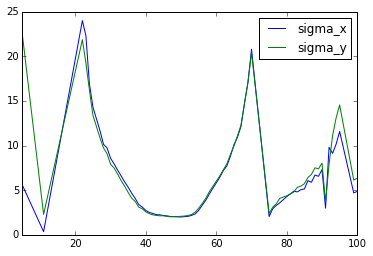

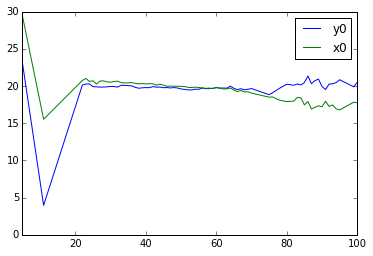

In [11]:
peakfits.plot(y=['sigma_x','sigma_y'])
peakfits.plot(y=['y0','x0'])

In [12]:
print(peakfits['sigma_x'][40:60].min())
print(peakfits['sigma_y'][40:60].min())

2.043696709184747
2.3831664619605086


In [13]:
peakfits.sort('amp')

,amp,x0,y0,sigma_x,sigma_y,offset
5,3.031128,29.398409,23.081984,5.541471,22.326661,110.411029
99,9.368310,17.824529,19.890125,4.691940,6.138009,108.921749
100,9.408804,17.742012,20.486990,4.869341,6.335128,108.184864
94,10.942307,16.926810,20.451458,10.148259,13.093585,106.375942
92,12.332887,17.261750,20.262989,9.795779,7.897034,107.445220
93,12.559041,17.453114,20.294043,9.122239,11.102187,105.964988
95,12.780850,16.784680,20.843280,11.574539,14.542234,105.157780
11,14.103206,15.534738,3.963143,0.346001,2.283651,112.948273
88,16.862637,17.123467,20.721969,6.689983,7.502390,108.585226
90,17.047212,17.201815,19.932347,7.304818,8.028104,109.132774
